In [3]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [4]:
import logging
from pathlib import Path

import numpy as np
import polars as pl

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import prepare_data
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance_per_participant import (
    analyze_per_participant,
    get_summary_statistics,
    plot_participant_performance,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

polars.config.Config

In [5]:
model, features, sample_length = load_model(
    "results/experiment_eda_phasic_eda_tonic/model/PatchTST_20250519-172911.pt"
)

# Load data from database
db = DatabaseManager()
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df, features, sample_length, RANDOM_SEED
)

test_groups = prepare_data(
    df, features, sample_length, RANDOM_SEED, only_return_test_groups=True
)
_, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)

17:03:32 | INFO    | utils | Using device: mps
17:03:32 | INFO    | utils | Loaded PatchTST model with test accuracy 0.86 to mps
17:03:32 | INFO    | utils | Input shape: (30, 2) | Features: ['eda_phasic', 'eda_tonic']
17:03:32 | DEBUG   | sample_creation | Removed 80 samples that were shorter than 2900.0 ms
17:03:33 | DEBUG   | data_preparation | Preparing data with sample duration 3000 ms and random seed 42
17:03:33 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'decreases': 'major_decreasing_intervals'}
17:03:33 | DEBUG   | data_preparation | Offsets for intervals: {'increases': 0, 'decreases': 2000}
17:03:33 | DEBUG   | data_preparation | Label mapping: {'increases': 0, 'decreases': 1}
17:03:33 | INFO    | data_preparation | Number of unique participants in training set: 24
17:03:33 | INFO    | data_preparation | Number of unique participants in validation set: 9
17:03:33 | INFO    | data_preparation | Number of unique 

In [6]:
results_df = analyze_per_participant(
    model,
    test_loader,
    test_groups,
    threshold=0.5,
    pseudonymize=True,
)
print(results_df)


shape: (10, 5)
┌─────────────┬──────────┬─────────┬───────────────┬───────────────┐
│ participant ┆ accuracy ┆ samples ┆ class_0_count ┆ class_1_count │
│ ---         ┆ ---      ┆ ---     ┆ ---           ┆ ---           │
│ str         ┆ f64      ┆ i64     ┆ i64           ┆ i64           │
╞═════════════╪══════════╪═════════╪═══════════════╪═══════════════╡
│ 1           ┆ 0.958333 ┆ 72      ┆ 36            ┆ 36            │
│ 2           ┆ 0.849315 ┆ 73      ┆ 37            ┆ 36            │
│ 3           ┆ 0.786667 ┆ 75      ┆ 39            ┆ 36            │
│ 4           ┆ 0.885714 ┆ 70      ┆ 34            ┆ 36            │
│ 5           ┆ 0.671642 ┆ 67      ┆ 31            ┆ 36            │
│ 6           ┆ 0.823529 ┆ 34      ┆ 16            ┆ 18            │
│ 7           ┆ 0.941176 ┆ 68      ┆ 35            ┆ 33            │
│ 8           ┆ 0.87013  ┆ 77      ┆ 41            ┆ 36            │
│ 9           ┆ 0.876712 ┆ 73      ┆ 37            ┆ 36            │
│ overall     ┆ 0.8

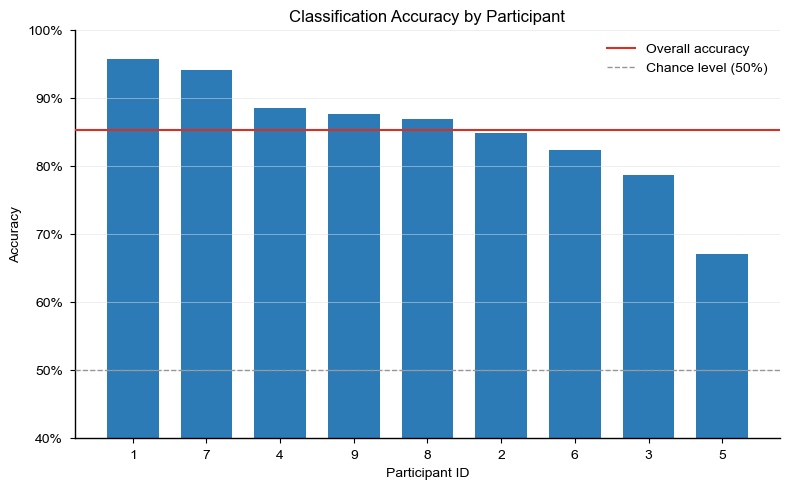

In [7]:
plot_participant_performance(results_df)

In [8]:
summary_df = get_summary_statistics(results_df)

print("Summary of classification accuracy across participants")
print(summary_df)

Summary of classification accuracy across participants
shape: (5, 2)
┌─────────────────────────────────┬───────────────┐
│ Measure                         ┆ Value         │
│ ---                             ┆ ---           │
│ str                             ┆ str           │
╞═════════════════════════════════╪═══════════════╡
│ Overall accuracy                ┆ 85.4%         │
│ Participants above chance leve… ┆ 9 out of 9    │
│ Participants above overall acc… ┆ 5 out of 9    │
│ Highest accuracy (Participant … ┆ 95.8% (ID: 1) │
│ Lowest accuracy (Participant I… ┆ 67.2% (ID: 5) │
└─────────────────────────────────┴───────────────┘
